In [6]:
import numpy as np
from numba import njit
from time import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
L_test = 10
p_test = 0.80

In [8]:
lattice_test = (np.random.random(size=(L_test, L_test)) < p_test).astype(int)

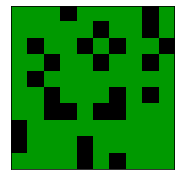

In [9]:
forest_colors = ListedColormap([[0,0,0], [0,0.6,0]])

plt.figure(figsize=(3,3))
plt.imshow(lattice_test, cmap = forest_colors)
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
@njit
def check_flow(lattice):

    burning_forest = lattice.copy()
    size = burning_forest.shape[0]
    
    time_step = 2
    burning_forest[0, :][burning_forest[0, :] == 1] = 2
    
    while (burning_forest[-1, :] <= 1).all(): 

        burning_cells = np.argwhere(burning_forest == time_step)
        
        if burning_cells.size == 0:
            return False
            
        else:
            for x, y in burning_cells:
                if x != 0     and burning_forest[x-1, y] == 1:
                    burning_forest[x-1, y] = time_step + 1
                if x != size - 1 and burning_forest[x+1, y] == 1:
                    burning_forest[x+1, y] = time_step + 1
                if y != 0     and burning_forest[x, y-1] == 1:
                    burning_forest[x, y-1] = time_step + 1
                if y != size - 1 and burning_forest[x, y+1] == 1:
                    burning_forest[x, y+1] = time_step + 1
            time_step += 1

    return True


In [13]:
check_flow(lattice_test)

True

In [14]:
@njit
def calculate_path_probabilities(probability_range, lattice_size, trials):

    path_probabilities_result = [0]
        
    for probability in probability_range:
        total_prob_sum = 0
        for _ in range(trials):
            lattice = (np.random.random(size=(lattice_size, lattice_size)) < probability).astype(np.int32)
            total_prob_sum += int(check_flow(lattice)) 
        path_probabilities_result.append(total_prob_sum / trials)

    return path_probabilities_result[1:]

In [15]:
@njit
def calculate_cluster_sizes(lattice_data):

    lattice_copy = lattice_data.copy()
    tree_positions = np.argwhere(lattice_copy == 1)

    cluster_label = 2

    if tree_positions.size == 0:
        return [0]
    else:
        for row, col in tree_positions:
            
            if row != 0 and col != 0:
                if lattice_copy[row, col-1] != 0 and lattice_copy[row-1, col] != 0:
                    lattice_copy[row, col] = lattice_copy[row-1, col]
                    for p, q in np.argwhere(lattice_copy == lattice_copy[row, col-1]):
                        lattice_copy[p, q] = lattice_copy[row-1, col]
                elif lattice_copy[row, col-1] != 0 and lattice_copy[row-1, col] == 0:
                    lattice_copy[row, col] = lattice_copy[row, col-1]
                elif lattice_copy[row, col-1] == 0 and lattice_copy[row-1, col] != 0:
                    lattice_copy[row, col] = lattice_copy[row-1, col]
                else:
                    lattice_copy[row, col] = cluster_label
                    cluster_label += 1
                
            elif row == 0 and col != 0:
                if lattice_copy[row, col-1] == 0:
                    lattice_copy[row, col] = cluster_label
                    cluster_label += 1
                else:
                    lattice_copy[row, col] = lattice_copy[row, col-1]
            elif row != 0 and col == 0:
                if lattice_copy[row-1, col] == 0:
                    lattice_copy[row, col] = cluster_label
                    cluster_label += 1
                else:
                    lattice_copy[row, col] = lattice_copy[row-1, col]
    
            else:
                lattice_copy[row, col] = cluster_label
                cluster_label += 1

        cluster_sizes_result = [np.count_nonzero(lattice_copy == n) for n in range(2, lattice_copy.max() + 1)]
        
        return cluster_sizes_result


In [16]:
max(calculate_cluster_sizes(lattice_test))


73

In [10]:
@njit
def calculate_cluster_distribution(probability, lattice_size, trials):

    distribution_result = np.zeros((1, lattice_size**2))
    
    partial_distribution = np.zeros((1, lattice_size**2))
    unique_sizes = np.arange(1, lattice_size**2 + 1, 1)
        
    for _ in range(trials):
        lattice_data = (np.random.random(size=(lattice_size, lattice_size)) < probability).astype(np.int32)
        cluster_sizes_result = calculate_cluster_sizes(lattice_data)
        sizes_distribution = np.array([cluster_sizes_result.count(size) / len(cluster_sizes_result) for size in unique_sizes])
        partial_distribution += sizes_distribution / trials

    distribution_result = np.concatenate((distribution_result, partial_distribution), axis=0)
    
    return distribution_result[1:, :][0]

            

In [11]:
@njit
def calculate_average_maximal_cluster(probability_range, lattice_size, trials):

    maximal_clusters_result = [0]
    
    for probability in probability_range:
    
        max_size_probability = 0
        
        for _ in range(trials):
    
            lattice_data = (np.random.random(size=(lattice_size, lattice_size)) < probability).astype(np.int32)
            max_size = max(calculate_cluster_sizes(lattice_data))
            max_size_probability += max_size / trials
    
        maximal_clusters_result.append(max_size_probability / (lattice_size**2))

    return maximal_clusters_result[1:]


In [12]:
with open('perc_ini.txt', 'r') as input_file:
    lines = input_file.readlines()

lattice_size_test = int(lines[0].strip().split()[1])
trials_test = int(lines[1].strip().split()[1])
initial_probability_test = float(lines[2].strip().split()[1])
final_probability_test = float(lines[3].strip().split()[1])
probability_step_test = float(lines[4].strip().split()[1])


In [13]:
probability_range_test = np.linspace(initial_probability_test, final_probability_test, int((final_probability_test - initial_probability_test) / probability_step_test) + 1)


In [14]:
lattice_size_test, trials_test, initial_probability_test, final_probability_test, probability_step_test


(100, 10000, 0.0, 1.0, 0.01)

In [20]:
flow_check_result = calculate_path_probabilities(probability_range_test, lattice_size_test, trials_test)


In [21]:
avg_max_cl_result = calculate_average_maximal_cluster(probability_range_test, lattice_size_test, trials_test)


In [31]:
probability_dist_test = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.592746]
probability_format_test = [str(p)[-1] for p in probability_dist_test[:-1]] + ['c']


In [23]:
with open(f'Ave_L{lattice_size_test}T{trials_test}.txt', 'w') as output_file_ave:
    for p, flow, s_max in zip(probability_range_test, flow_check_result, avg_max_cl_result):
        output_file_ave.write(f'{p}  {flow}  {s_max}\n')


In [16]:
for p, p_f in zip(probability_dist_test, probability_format_test):
    cluster_dist_result = calculate_cluster_distribution(p, lattice_size_test, trials_test)
    size_range_test = np.arange(1, lattice_size_test**2, 1)
    with open(f'Dist_p0{p_f}L{lattice_size_test}T{trials_test}.txt', 'w') as output_file_dist:
        for size, count in zip(size_range_test, cluster_dist_result):
            output_file_dist.write(f'{size}  {count}\n')


In [24]:
with open(f'Ave_L100T10000.txt', 'r') as ave_plot_file:
    lines = ave_plot_file.readlines()
    probability_range_read = [float(row.strip().split()[0]) for row in lines]
    flow_check_read = [float(row.strip().split()[1]) for row in lines]
    avg_max_cl_read = [float(row.strip().split()[2]) for row in lines]


In [16]:
probability_range_10 = probability_range_read
flow_check_10 = flow_check_read
avg_max_cl_10 = avg_max_cl_read


In [18]:
probability_range_50 = probability_range_read
flow_check_50 = flow_check_read
avg_max_cl_50 = avg_max_cl_read


In [25]:
probability_range_100 = probability_range_read
flow_check_100 = flow_check_read
avg_max_cl_100 = avg_max_cl_read


In [52]:
with open(f'Dist_p02L100T10000.txt', 'r') as dist_plot_file:
    lines = dist_plot_file.readlines()
    size_range_read = [float(row.strip().split()[0]) for row in lines]
    count_range_read = [float(row.strip().split()[1]) for row in lines]


In [53]:
size_range_02 = size_range_read
count_range_02 = count_range_read


In [51]:
size_range_03 = size_range_read
count_range_03 = count_range_read


In [49]:
size_range_04 = size_range_read
count_range_04 = count_range_read


In [47]:
size_range_05 = size_range_read
count_range_05 = count_range_read


In [45]:
size_range_06 = size_range_read
count_range_06 = count_range_read


In [43]:
size_range_07 = size_range_read
count_range_07 = count_range_read


In [41]:
size_range_08 = size_range_read
count_range_08 = count_range_read


In [39]:
size_range_09 = size_range_read
count_range_09 = count_range_read


In [35]:
size_range_c = size_range_read
count_range_c = count_range_read


In [26]:
size_values = [10, 50, 100]
marker_types = ['o', 's', '^']
marker_sizes = [4, 4, 6]


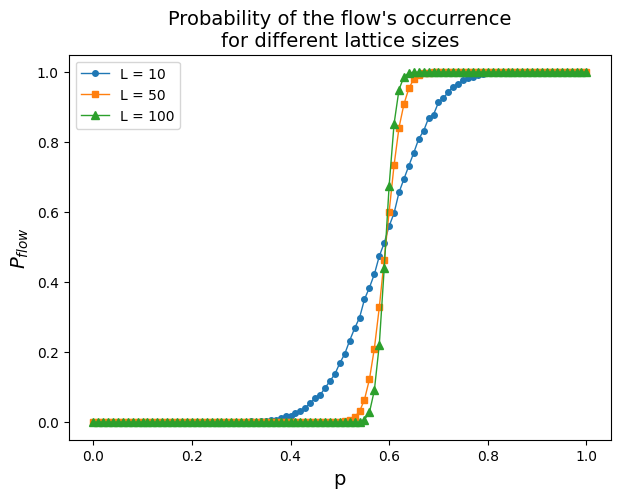

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for size, marker_type, marker_size in zip(size_values, marker_types, marker_sizes):
    plt.plot(eval(f'probability_range_{size}'), eval(f'flow_check_{size}'), label=f'L = {size}', marker=marker_type, markersize=marker_size, linewidth=1)

plt.title('Probability of the flow\'s occurrence\nfor different lattice sizes', fontsize=14)
plt.xlabel('p', fontsize=14)
plt.ylabel(r'$P_{flow}$', fontsize=14)
plt.legend()
plt.show()


In [32]:
colors_sub = ['green', 'goldenrod', 'royalblue', 'indianred']
colors_over = ['darkslateblue', 'orange', 'darkolivegreen', 'crimson']

marker_types_dist = ['o', 's', '^', 'D']
marker_sizes_dist = [3, 3, 5, 3]


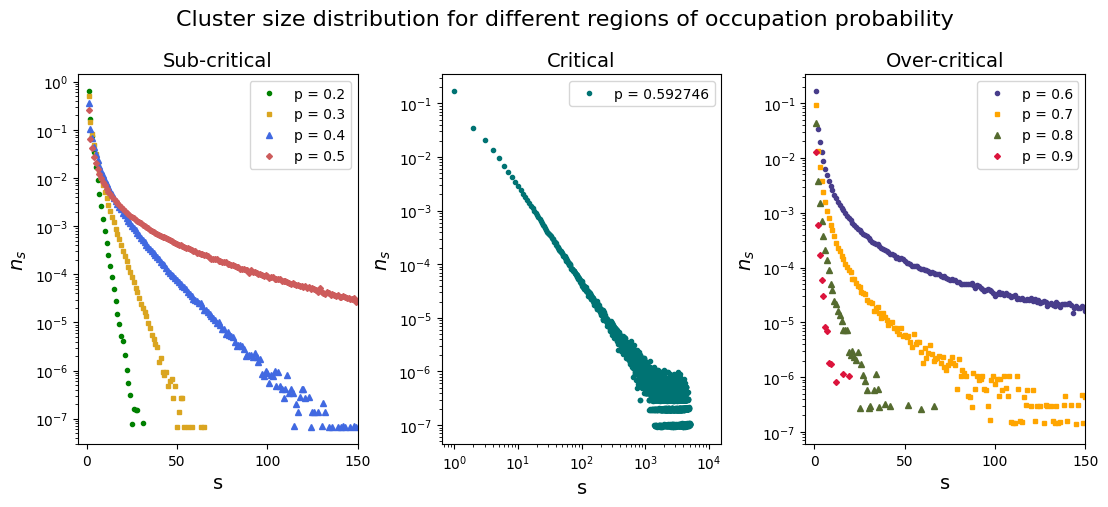

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))

plt.suptitle('Cluster size distribution for different regions of occupation probability', fontsize=16)
plt.subplots_adjust(wspace=0.3, top=0.85)

plt.subplot(1, 3, 1)
for p_f, c, m, s in zip(probability_format_test[:4], colors_sub, marker_types_dist, marker_sizes_dist):
    plt.plot(eval(f'size_range_0{p_f}'), eval(f'count_range_0{p_f}'), marker=m, markersize=s, linewidth=0, label=f'p = 0.{p_f}', color=c)
plt.title('Sub-critical', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.ylabel(r'$n_s$', fontsize=14)
plt.yscale('log')
plt.xlim(-5, 150)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(size_range_c, count_range_c, marker='o', markersize=3, linewidth=0, color=[0, 0.45, 0.45])
plt.title('Critical', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.ylabel(r'$n_s$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(['p = 0.592746'])

plt.subplot(1, 3, 3)
for p_f, c, m, s in zip(probability_format_test[4:8], colors_over, marker_types_dist, marker_sizes_dist):
    plt.plot(eval(f'size_range_0{p_f}'), eval(f'count_range_0{p_f}'), marker=m, markersize=s, linewidth=0, label=f'p = 0.{p_f}', color=c)
plt.title('Over-critical', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.ylabel(r'$n_s$', fontsize=14)
plt.yscale('log')
plt.xlim(-5, 150)
plt.ylim(6e-8, None)
plt.legend()

plt.show()


In [63]:
@njit
def propagate_fire(lattice_data):

    forest = lattice_data.copy()
    L = forest.shape[0]
    
    t = 2
    forest[0, :][forest[0, :] == 1] = 2
    
    while (forest[-1, :] <= 1).all(): 

        burning_idx = np.argwhere(forest == t)
        
        if burning_idx.size == 0:
            return forest
            
        else:
            for x, y in burning_idx:
                if x != 0     and forest[x-1, y] == 1:
                    forest[x-1, y] = t + 1
                if x != L - 1 and forest[x+1, y] == 1:
                    forest[x+1, y] = t + 1
                if y != 0     and forest[x, y-1] == 1:
                    forest[x, y-1] = t + 1
                if y != L - 1 and forest[x, y+1] == 1:
                    forest[x, y+1] = t + 1
            t += 1

    return forest


In [64]:
@njit
def label_clusters(lattice_data):

    forest = lattice_data.copy()
    trees = np.argwhere(forest == 1)

    k = 2

    if trees.size == 0:
        return np.int32(2) * forest
    else:
        for x, y in trees:
            
            if x != 0 and y != 0:
                if forest[x, y-1] != 0 and forest[x-1, y] != 0:
                    forest[x, y] = forest[x-1, y]
                    for p, q in np.argwhere(forest == forest[x, y-1]):
                        forest[p, q] = forest[x-1, y]
                elif forest[x, y-1] != 0 and forest [x-1, y] == 0:
                    forest[x, y] = forest[x, y-1]
                elif forest[x, y-1] == 0 and forest [x-1, y] != 0:
                    forest[x, y] = forest[x-1, y]
                else:
                    forest[x, y] = k
                    k += 1
                
            elif x == 0 and y != 0:
                if forest[x, y-1] == 0:
                    forest[x, y] = k
                    k += 1
                else:
                    forest[x, y] = forest[x, y-1]
            elif x != 0 and y == 0:
                if forest[x-1, y] == 0:
                    forest[x, y] = k
                    k += 1
                else:
                    forest[x, y] = forest[x-1, y]
    
            else:
                forest[x, y] = k
                k += 1

        return forest


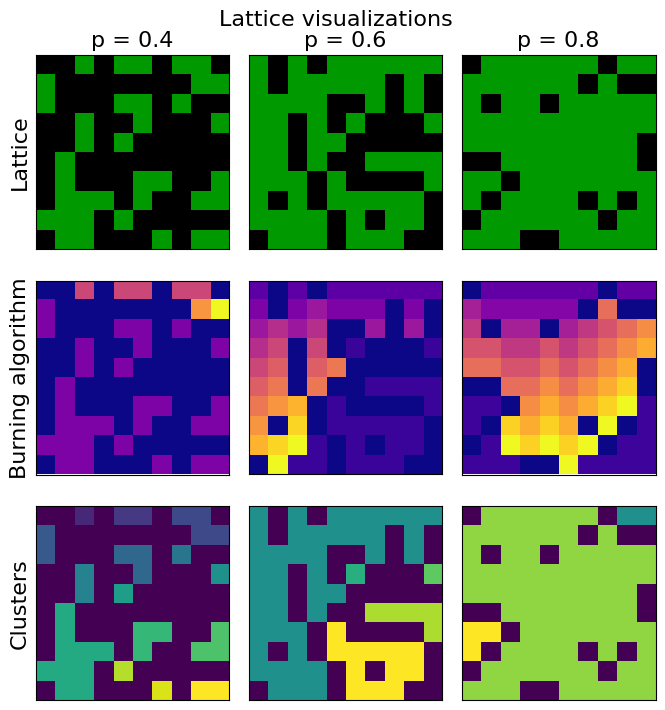

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.suptitle('Lattice visualizations', fontsize=16)
plt.subplots_adjust(top=0.93, wspace=0.1, hspace=0.1)

for idx, p_vis in enumerate([0.4, 0.6, 0.8]):
    lattice_data = (np.random.random(size=(10, 10)) < p_vis).astype(int)
    fire_result = propagate_fire(lattice_data)
    clusters_result = label_clusters(lattice_data)

    plt.subplot(3, 3, 1 + idx)
    plt.imshow(lattice_data, cmap=forest_colors)
    plt.title(f'p = {p_vis}', fontsize=16)
    if idx == 0:
        plt.ylabel('Lattice', fontsize=16)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 3, 4 + idx)
    plt.imshow(fire_result, cmap='plasma')
    if idx == 0:
        plt.ylabel('Burning algorithm', fontsize=16)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 3, 7 + idx)
    plt.imshow(clusters_result, cmap='viridis')
    if idx == 0:
        plt.ylabel('Clusters', fontsize=16)    
    plt.xticks([])
    plt.yticks([])

plt.show()
